In [21]:

import os
import tqdm
import errno
import numpy as np
import pandas as pd
import sys
sys.path.append('gamtools')






import gzip
import matplotlib.pyplot as plt
import cooler
import cooltools.lib.plotting
import scipy
from scipy import stats
import random
from sklearn.preprocessing import LabelEncoder


from multiprocessing import Pool
from functools import partial


from scipy.signal import convolve2d
from scipy import ndimage
from scipy.spatial import ConvexHull#处理凸包
from scipy.spatial.distance import pdist, squareform

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# from gamtools import segregation, cosegregation
# import sys
# sys.path.append('/shareb/zliu/analysis/')
# from CHARMtools import imputation,Cell3D
# import imp
# imp.reload(imputation) 
# imp.reload(Cell3D)

## 0.Function

In [22]:
def point_cloud_rotation(point_cloud, x_angle=None,y_angle=None,z_angle=None):
    if x_angle:
        rotation_matrix = np.array([[1,0,0],[0,np.cos(x_angle),-np.sin(x_angle)],[0,np.sin(x_angle),np.cos(x_angle)]])
        point_cloud = np.dot(point_cloud,rotation_matrix)
    if y_angle:
        rotation_matrix = np.array([[np.cos(y_angle),0,np.sin(y_angle)],[0,1,0],[-np.sin(y_angle),0,np.cos(y_angle)]])
        point_cloud = np.dot(point_cloud,rotation_matrix)
    if z_angle:
        rotation_matrix = np.array([[np.cos(z_angle),-np.sin(z_angle),0],[np.sin(z_angle),np.cos(z_angle),0],[0,0,1]])
        point_cloud = np.dot(point_cloud,rotation_matrix)

    return point_cloud

def plot_metrics(x,xlabel,pearson,spearman,ssmi,rms):
    # line plot of corrs ssmis and rms vs width
    fig, axes = plt.subplots(1, 4, figsize=(10, 3),dpi=120)

    axes[0].plot(x, pearson, color='tab:blue')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Pearson corrs')
    axes[0].set_title('Pearson corrs')

    axes[1].plot(x, spearman, color='tab:blue')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel('Spearman corrs')
    axes[1].set_title('Spearman corrs')

    axes[2].plot(x, ssmi, color='tab:blue')
    axes[2].set_xlabel(xlabel)
    axes[2].set_ylabel('SSMIs')
    axes[2].set_title('SSMIs')

    axes[3].plot(x, rms, color='tab:blue')
    axes[3].set_xlabel(xlabel)
    axes[3].set_ylabel('RMSs')
    axes[3].set_title('RMSs')

    plt.tight_layout()
    plt.show()
    
def generate_slices_uniform(tdg_path,CpG_df,slice_width=6,slice_num=1):
    tdg = pd.read_csv(tdg_path,sep="\t",header = None)
    tdg.columns = ["chrom","start","x","y","z"]
    
    # print(CpG_df.head())
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000
    # print(tdg.head())

    slices = []
    for slice in range(slice_num):
        rotated = point_cloud_rotation(tdg[["x","y","z"]].values,
                                        x_angle=np.random.uniform(0, 2*np.pi),
                                        y_angle=np.random.uniform(0, 2*np.pi),
                                        z_angle=np.random.uniform(0, 2*np.pi)
                                        )

        tdg_temp = tdg[["chrom","pos"]]
        tdg_temp = tdg_temp.assign(x=rotated[:,0],y=rotated[:,1],z=rotated[:,2])
        
        xrange = (tdg_temp["x"].min(),tdg_temp["x"].max())
        
        slice_upper = np.random.uniform(xrange[0]+slice_width,xrange[1])
        slice_lower = slice_upper - slice_width

        slice_tmp = tdg_temp.query(f'x > @slice_lower & x < @slice_upper').assign(inslice = lambda x: 1)[["chrom","pos","inslice"]]

        
        slice = pd.merge(CpG_df,slice_tmp,how="left").fillna(0)  
        slices.append(slice["inslice"].values)
    return slices

def generate_slices(tdg_path,CpG_df,slice_width=6,slice_num=1):
    tdg = pd.read_csv(tdg_path,sep="\t",header = None)
    tdg.columns = ["chrom","pos","x","y","z"]
    tdg["pos"] = tdg["pos"].astype(int) - 20000

    slices = []
    for slice in range(slice_num):

        rotated = point_cloud_rotation(tdg[["x","y","z"]].values,
                                        x_angle=np.random.uniform(0, 2*np.pi),
                                        y_angle=np.random.uniform(0, 2*np.pi),
                                        z_angle=np.random.uniform(0, 2*np.pi)
                                        )

        tdg_temp = tdg[["chrom","pos"]]
        tdg_temp = tdg_temp.assign(x=rotated[:,0],y=rotated[:,1],z=rotated[:,2])
        
        xrange = (tdg_temp["x"].min(),tdg_temp["x"].max())
        
        # 计算点云的中心
        center_x = tdg_temp["x"].mean()
        slice_center = np.random.normal(center_x, slice_width / 2)
        slice_lower = max(slice_center - slice_width / 2, tdg_temp["x"].min())
        slice_upper = min(slice_center + slice_width / 2, tdg_temp["x"].max())

        # slice_upper = np.random.uniform(xrange[0]+slice_width,xrange[1])
        # slice_lower = slice_upper - slice_width

        slice = tdg_temp.query(f'x > @slice_lower & x < @slice_upper').assign(inslice = lambda x: 1)[["chrom","pos","inslice"]]
        slice = pd.merge(CpG_df,slice,how="left").fillna(0)
        slices.append(slice["inslice"].values)
    return slices



def plot_single_matrix(matrix,cmap="fall",title=None,vmax=1,vmin=0):
    plt.figure(figsize=(8, 3),dpi=120)
    plt.subplot(1, 2, 1)
    plt.imshow(matrix, cmap=cmap,vmax=vmax,vmin=vmin)
    plt.colorbar(label=title)
    plt.title(title)

    
    
def mat_cor_with_na(mat1,mat2,sample):
    # Calculate distance matrices
    distance_matrix_1 = mat1.flatten()
    distance_matrix_2 = mat2.flatten()

    # Replace inf values with nan
    distance_matrix_1 = np.where(np.isinf(distance_matrix_1), np.nan, distance_matrix_1)
    distance_matrix_2 = np.where(np.isinf(distance_matrix_2), np.nan, distance_matrix_2)

    # Remove any NaN values from both arrays (only where both have NaNs in the same position)
    mask = ~np.isnan(distance_matrix_1) & ~np.isnan(distance_matrix_2)

    distance_matrix_1 = distance_matrix_1[mask]
    distance_matrix_2 = distance_matrix_2[mask]

    #sample 
    if sample:
        sample_index = np.random.choice(len(distance_matrix_1), sample, replace=False)
        distance_matrix_1 = distance_matrix_1[sample_index]
        distance_matrix_2 = distance_matrix_2[sample_index]

    # Check if there are any remaining NaNs or infs
    if not np.isfinite(distance_matrix_1).all() or not np.isfinite(distance_matrix_2).all():
        raise ValueError("The input arrays contain infs or NaNs after preprocessing.")

    # Now you can safely call pearsonr
    print(f"length is {len(distance_matrix_1)}")
    pearsonr_value,_ = stats.pearsonr(distance_matrix_1, distance_matrix_2)
    spearmanr_value,_ = stats.spearmanr(distance_matrix_1, distance_matrix_2)
    normalized_mat1 = (mat1 - np.nanmean(mat1)) / np.nanstd(mat1)
    normalized_mat2 = (mat2 - np.nanmean(mat2)) / np.nanstd(mat2)
    normalized_mat1[np.isnan(normalized_mat1)] = 0
    normalized_mat2[np.isnan(normalized_mat2)] = 0
    ssmis = ssim(normalized_mat1, normalized_mat2)
    mse = mean_squared_error(normalized_mat1, normalized_mat2)

    return [pearsonr_value,spearmanr_value,ssmis,mse]
def Calculating_diagonal_data(matrix):
    N, M = len(matrix), len(matrix[0])
    Diagonal_mean = np.full(M, 0.0)
    Diagonal_std = np.full(M, 0.0)
    std = []
    for d in range(N):
        intermediate = []
        c = d
        r = 0
        while r < N - d:
            intermediate.append(matrix[r][c])
            r += 1
            c += 1
        intermediate = np.array(intermediate)
        Diagonal_mean[d] = (np.nanmean(intermediate))
        Diagonal_std[d] = (np.nanstd(intermediate))
    return Diagonal_mean, Diagonal_std


def Distance_normalization(rawmatrix):
    
    Diagonal_mean, Diagonal_std = Calculating_diagonal_data(rawmatrix)
    N, M = len(rawmatrix), len(rawmatrix[0])
    matrix = np.full((N, M), np.nan)
    for d in range(N):
        c = d
        r = 0
        while r < N - d:
            if Diagonal_mean[d] != np.nan and Diagonal_std[d] != 0:
                matrix[r][c] = (rawmatrix[r][c] - Diagonal_mean[d]) / Diagonal_std[d]
            r += 1
            c += 1
    for r in range(N):
        for c in range(r+1, M):
            matrix[c][r] = matrix[r][c]
    return matrix



# plot df_gam_Dprime_matrix_chr4_region
def plot_matrix(matrix,title,region_start,region_end,cmap,vmax,vmin):
    plt.figure(figsize=(3,3), facecolor='white')
    plt.imshow(matrix,
               extent=(region_start, region_end, region_end, region_start),
               interpolation='none', vmin=vmin, vmax=vmax, cmap=cmap)

    plt.title(title)
    ax = plt.gca()

    ax.yaxis.set_ticks_position('left')   # 设置y轴刻度仅在左侧显示
    ax.xaxis.set_ticks_position('bottom') # 设置x轴刻度仅在底部显

    #show colorbar
    cbar = plt.colorbar()
    cbar.set_label(title)
    cbar.set_ticks([vmin,0,vmax])
    cbar.set_ticklabels([vmin,0,vmax])
    #设置cbar大小

def get_merged(original_segmentation, merge=2):
    column_indexes = list(range(len(original_segmentation.columns)))

    # Shuffle column indexes in place
    np.random.shuffle(column_indexes)

    # Group them in threes
    index_sets = list(utils.grouper(column_indexes, merge))

    # Merge random columns of the segmentation in groups of three
    return pd.concat(
        [original_segmentation.iloc[:,indexes].any(axis=1).astype(int) for indexes in index_sets],
        axis=1)

def normalize_gam_matrix(gam_matrix, mean_slices):
    # 定义标准化后的矩阵
    normalized_matrix = np.zeros_like(gam_matrix)
    # 获取矩阵的行数和列数
    rows, cols = gam_matrix.shape
    # 遍历矩阵中的每个元素
    for i in range(rows):
        for j in range(cols):
            # 提取当前元素
            D = gam_matrix[i, j]
            # 计算 f_a 和 f_b
            f_a = mean_slices[i]
            f_b = mean_slices[j]

            # 应用标准化规则
            if D < 0:
                normalized_matrix[i, j] = min(f_a * f_b, (1 - f_a) * (1 - f_b))
            else:
                normalized_matrix[i, j] = min(f_b * (1 - f_a), f_a * (1 - f_b))

    return normalized_matrix

## 1.GAM data

(3891, 3891)


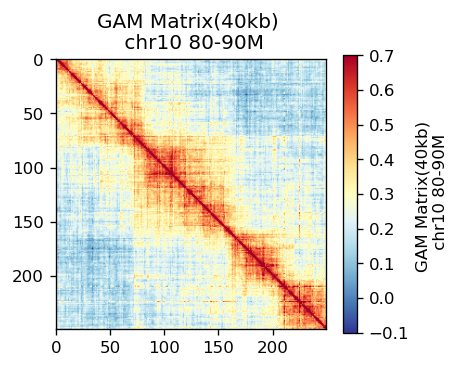

In [23]:
#mm9的
gam_chr4_40kb_path = "/shareb/mliu/HiMulti/data/multiplex_GAM/dprime_matrix/combined_segregation_at_40kb.chr4_dprime.txt.gz"
with gzip.open(gam_chr4_40kb_path, 'rt') as f:
    df_gam_chr4_40kb = pd.read_csv(f, header=0,index_col=0,sep='\t')  # 假设数据以制表符分隔
data_gam_chr4_40kb = np.array(df_gam_chr4_40kb)

data_gam_chr4_40kb_local = data_gam_chr4_40kb[2000:2250,2000:2250]
plot_single_matrix(data_gam_chr4_40kb_local,cmap="RdYlBu_r",title="GAM Matrix(40kb) \n chr10 80-90M",vmax=0.7,vmin=-0.1)
print(data_gam_chr4_40kb.shape)

In [4]:
#mm10
# df_segregation_mm10 = pd.read_csv("/shareb/mliu/HiMulti/data/multiplex_GAM/rawdata/mm10/segregation_at_40kb.passed_qc.table",sep="\t",index_col=[0,1,2])
# test_region = 'chr4:80000000-90000000'
# chr4_region = 'chr4'
# start_pos = "80M"
# end_pos = "90M"
# # gam_dprime_mm10_chr4 = np.load("mm10_chr4_dprime.npy")
# gam_dprime_mm10_chr4_region = cosegregation.get_dprime(df_segregation_mm10, test_region)
# gam_dprime_mm10_chr4 = cosegregation.get_dprime(df_segregation_mm10, chr4_region)
# plot_single_matrix(gam_dprime_mm10_chr4_region,cmap="RdYlBu_r",title="GAM Matrix(40kb) \n chr10 80-90M",vmax=0.7,vmin=-0.1)
# print(gam_dprime_mm10_chr4.shape)

## bin data

In [24]:
df_mm10 = pd.read_csv("/shareb/mliu/HiMulti/data/multiplex_GAM/rawdata/genome/mm10.chrom.sizes",sep="\t",header=None)
df_mm10.columns = ['chrom','size']
resolution = 40000
bins = []

# 遍历每个染色体，生成对应的bins
for index, row in df_mm10.iterrows():
    chrom = row['chrom']
    size = row['size']
    for start in range(0, size, resolution):
        stop = min(start + resolution, size)
        pos = (start + stop) // 2
        bins.append([chrom, start, stop, pos])

# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
bin_table_df_mat = bin_table_df.copy()
bin_table_df_mat['chrom'] = bin_table_df_mat['chrom'].apply(lambda x: x+"(mat)")
bin_table_df_pat = bin_table_df.copy()
bin_table_df_pat['chrom'] = bin_table_df_pat['chrom'].apply(lambda x: x+"(pat)")
df_bin_mm10_40kb = pd.concat([bin_table_df_mat,bin_table_df_pat],axis=0)

df_mm9 = pd.read_csv("/shareb/mliu/HiMulti/ref_data/mm9.chrom.sizes",sep="\t",header=None)
df_mm9.columns = ['chrom','size']
resolution = 40000
bins = []

# 遍历每个染色体，生成对应的bins
for index, row in df_mm9.iterrows():
    chrom = row['chrom']
    size = row['size']
    for start in range(0, size, resolution):
        stop = min(start + resolution, size)
        pos = (start + stop) // 2
        bins.append([chrom, start, stop, pos])

# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
bin_table_df_mat = bin_table_df.copy()
bin_table_df_mat['chrom'] = bin_table_df_mat['chrom'].apply(lambda x: x+"(mat)")
bin_table_df_pat = bin_table_df.copy()
bin_table_df_pat['chrom'] = bin_table_df_pat['chrom'].apply(lambda x: x+"(pat)")
df_bin_mm9_40kb = pd.concat([bin_table_df_mat,bin_table_df_pat],axis=0)
df_bin_mm9_40kb.index = range(len(df_bin_mm9_40kb))


ref = "mm9"
df_mm = pd.read_csv(f"ref_data/{ref}.chrom.sizes",sep="\t",header=None)
df_mm.columns = ['chrom','size']
df_mm = df_mm.query("chrom!='chrX' and chrom != 'chrY'")
resolution = 40000
bins = []

# 遍历每个染色体，生成对应的bins
for index, row in df_mm.iterrows():
    chrom = row['chrom']
    size = row['size']
    for start in range(0, size, resolution):
        stop = min(start + resolution, size)
        pos = (start + stop) // 2
        bins.append([chrom, start, stop, pos])

# 将bins列表转换为DataFrame
bin_table_df = pd.DataFrame(bins, columns=['chrom', 'start', 'stop', 'pos'])
chr_list = list(bin_table_df['chrom'].unique())

bin

## Meta data

In [25]:
metadata = pd.read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0728/stat/stat_0728.csv")
cellnames1 = metadata[metadata['cellname'].str.startswith('d0')].query("`20k` < 1.5 & cellname != 'd0C3' & cellname != 'd0C5'")['cellname'].values
print(f"There are {len(cellnames1)} mESC cells")## 切一片

import pickle
with open('mESC2_cellname.pkl', 'rb') as file:
    cellnames2 = pickle.load(file)
print(f"There are {len(cellnames2)} mESC cells")## 切一片

There are 38 mESC cells
There are 163 mESC cells


## Hi-C data

In [26]:
regin_40kb = "chr4(mat)"
regin_40kb_local = "chr4(mat):80000000-90000000"

mesc1_path = "/shareb/mliu/HiMulti/data/mESC/mcool"
mesc2_path = "/shareb/mliu/HiMulti/data/mESC2/cooler"
mesc2_mm9_path = "/shareb/mliu/HiMulti/data/mESC2/mm9/mcool"
surfix1="balanced.mcool"
surfix2 = "mcool"
surfix2_mm9 = "mm9.mcool"

cellnames = cellnames2
mesc_path = mesc2_mm9_path
surfix = surfix2_mm9

clr_40k = cooler.Cooler(f"{mesc_path}/{cellnames[0]}.{surfix}::/resolutions/40000")


mat_40k = clr_40k.matrix(balance=False).fetch(regin_40kb)
mat_hic_40k = np.zeros((mat_40k.shape[0],mat_40k.shape[0]))
mat_40k_local = clr_40k.matrix(balance=False).fetch(regin_40kb_local)
mat_40k_local = np.zeros((mat_40k_local.shape[0],mat_40k_local.shape[0]))


for cellname in tqdm.tqdm(cellnames):
    if os.path.exists(f"{mesc_path}/{cellname}.{surfix}"):
        clr=cooler.Cooler(f"{mesc_path}/{cellname}.{surfix}::/resolutions/40000")
        mat_hic_40k += clr.matrix(balance=False).fetch(regin_40kb)
        mat_40k_local += clr.matrix(balance=False).fetch(regin_40kb_local)


  2%|▏         | 3/163 [00:00<00:24,  6.63it/s]

100%|██████████| 163/163 [00:19<00:00,  8.28it/s]


In [1]:
plot_single_matrix(mat_40k_local,cmap="Reds",title="Hi-C Matrix(40kb) \n chr4(mat) 80M-90M",vmax=10,vmin=0)

NameError: name 'plot_single_matrix' is not defined

In [28]:
print(mat_hic_40k.shape)
pearsonr_value,spearmanr_value,ssmis,mse = mat_cor_with_na(mat_hic_40k,data_gam_chr4_40kb,sample=False) 
print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}\nmse is {mse}")

(3891, 3891)


length is 14137600
pearsonr_value is 0.24888639607304924
spearmanr_value is 0.23577784177251368
ssmis is 0.008707946385757653
mse is 1.4530893559331797


In [29]:
regin_40kb = "chr4(pat)"
regin_40kb_local = "chr4(pat):80000000-90000000"

mesc1_path = "/shareb/mliu/HiMulti/data/mESC/mcool"
mesc2_path = "/shareb/mliu/HiMulti/data/mESC2/cooler"
surfix1="balanced.mcool"
surfix2 = "mcool"


cellnames = cellnames2
mesc_path = mesc2_path
surfix = surfix2

clr_40k = cooler.Cooler(f"{mesc_path}/{cellnames[0]}.{surfix}::/resolutions/40000")


mat_40k = clr_40k.matrix(balance=False).fetch(regin_40kb)
mat_hic_40k = np.zeros((mat_40k.shape[0],mat_40k.shape[0]))
mat_40k_local = clr_40k.matrix(balance=False).fetch(regin_40kb_local)
mat_40k_local = np.zeros((mat_40k_local.shape[0],mat_40k_local.shape[0]))


for cellname in tqdm.tqdm(cellnames):
    if os.path.exists(f"{mesc_path}/{cellname}.{surfix}"):
        clr=cooler.Cooler(f"{mesc_path}/{cellname}.{surfix}::/resolutions/40000")
        mat_hic_40k += clr.matrix(balance=False).fetch(regin_40kb)
        mat_40k_local += clr.matrix(balance=False).fetch(regin_40kb_local)


100%|██████████| 163/163 [00:32<00:00,  4.96it/s]


(3913, 3913)


NameError: name 'gam_dprime_mm10_chr4' is not defined

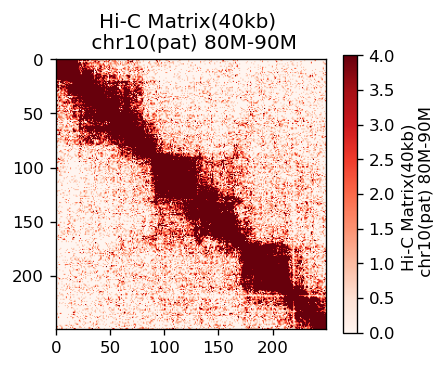

In [30]:
plot_single_matrix(mat_40k_local,cmap="Reds",title="Hi-C Matrix(40kb) \n chr10(pat) 80M-90M",vmax=4,vmin=0)
print(mat_hic_40k.shape)
pearsonr_value,spearmanr_value,ssmis,mse = mat_cor_with_na(mat_hic_40k,gam_dprime_mm10_chr4,sample=False) 
print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}\nmse is {mse}")

## 3dg Matrix

In [31]:
tdg_paths_40k_mm10 = [f"/shareb/mliu/HiMulti/data/mESC/tdg/{cellname}/clean.40k.0.3dg" for cellname in cellnames1]
tdg_paths_40k2_mm10 = [f"/share/home/mliu/shareb/mliu/HiMulti/data/mESC2/tdg/{cellname}/clean.40k.0.3dg" for cellname in cellnames2]

tdg_mm9_40kb_dir = "/shareb/mliu/HiMulti/data/mESC2/mm9/processed_tdg"

tdg_paths_40k2_mm9 = [f"{tdg_mm9_40kb_dir}/{file}" for file in os.listdir(tdg_mm9_40kb_dir)]
print(len(tdg_paths_40k2_mm9))

chrom_legnth_path_mm10 = "/shareb/mliu/HiMulti/ref_data/dip.len.mm10"
chrom_legnth_path_mm9 = "/shareb/mliu/HiMulti/ref_data/dip.len.mm9"

191


In [6]:

tdg_path = tdg_paths_40k[0]
resolution = 40000
cell = Cell3D.Cell3D(cellname="cell", tdg_path=tdg_path, resolution=resolution)
cell.add_chrom_length(chrom_legnth_path)
distance_mat = cell.calc_distance_matrix("chr4b:80000000-90000000")
print(distance_mat.shape)

NameError: name 'Cell3D' is not defined

`直径`

In [40]:
#看直径
v_list = []
cellnames = cellnames1
for cellname in cellnames.tolist():
    # print(f"/shareb/mliu/HiMulti/data/mESC/tdg/{cellname}/clean.40k.0.3dg")
    tdg40k = pd.read_csv(f"/shareb/mliu/HiMulti/data/mESC/tdg/{cellname}/clean.40k.0.3dg",sep="\t",header = None)
    tdg40k.columns = ["chrom","pos","x","y","z"]
    coordinates = tdg40k[['x', 'y', 'z']].values
    convex_hull = ConvexHull(coordinates)
    volume = convex_hull.volume
    v_list.append(volume)
R = (np.average(v_list)*(3/4)/3.14)**(1/3)
print(R)

35.16600130618224


In [54]:
#计算平均
size = df_bin_mm10_40kb.query("chrom=='chr4(mat)'").shape[0]
print(size)
distance_mat = np.zeros((size,size))
resolution = 40000
mat_list = []
for tdg in tdg_paths_40k:
    cell = Cell3D.Cell3D(cellname="cell", tdg_path=tdg, resolution=resolution)
    cell.add_chrom_length(chrom_legnth_path)
    mat = cell.calc_distance_matrix("chr4b")
    mat_list.append(mat)
mat_list_array = np.array(mat_list)
print(mat_list_array.shape)

3913
(38, 3913, 3913)


In [55]:
# distance_mat_avg中nan
distance_mat_avg = np.nanmean(mat_list_array, axis=0)

/tmp/ipykernel_131348/377452271.py:2: RuntimeWarning: Mean of empty slice
  distance_mat_avg = np.nanmean(mat_list_array, axis=0)


In [45]:
#计算平均 看一下可视化
distance_mat_local = np.zeros((250,250))
resolution = 40000
sum =0
for tdg in tdg_paths_40k:
    # print(tdg)
    cell = Cell3D.Cell3D(cellname="cell", tdg_path=tdg, resolution=resolution)
    cell.add_chrom_length(chrom_legnth_path)
    local_distance_matrix = cell.calc_distance_matrix("chr4b:80000000-90000000")
    distance_mat_local += local_distance_matrix   
    sum += 1
distance_mat_avg_local = distance_mat_local / sum
print(sum)

38


length is 14212900
pearsonr_value is 0.362062944237058
spearmanr_value is 0.5004778765053758
ssmis is 0.04607527400703475
mse is 1.2356013258211118


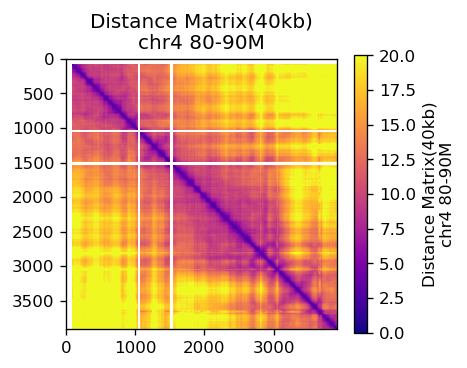

In [59]:
#40-48Mb
plot_single_matrix(distance_mat_avg,cmap="plasma",title="Distance Matrix(40kb)\nchr4 80-90M",vmax=20,vmin=0)
pearsonr_value,spearmanr_value,ssmis,mse = mat_cor_with_na(gam_dprime_mm10_chr4,-1*distance_mat_avg,sample=False)
print(f"pearsonr_value is {pearsonr_value}\nspearmanr_value is {spearmanr_value}\nssmis is {ssmis}\nmse is {mse}")

## Slice num

In [32]:
region = "chr4(mat)"
region_local = "chr4(mat):80000000-90000000"
slice_nums = np.linspace(1,1000,10,dtype=int)
gam_D = []
gam_D_local = []
df_bin = df_bin_mm9_40kb
for slice_num in slice_nums:
    slice_results = []   
    for tdg_path in tqdm.tqdm(tdg_paths_40k2_mm9):
        cellname = tdg_path.split('/')[-2]
        slices_result = generate_slices_uniform(tdg_path, CpG_df=df_bin, slice_width=2.5, slice_num=slice_num)
        slice_results.append(slices_result)  
        
    slices = np.array([item for sublist in slice_results for item in sublist]).T
    
    mat_index = df_bin[df_bin['chrom'] == region.split(':')[0]].index
    slices_temp = slices[mat_index,:]
    mean_slices = slices_temp.mean(axis=1)
    mean_both = slices_temp @ slices_temp.T / slices_temp.shape[1]
    mean_product = np.outer(mean_slices, mean_slices)
    gam_matrix = mean_both - mean_product
    gam_D.append(gam_matrix)

    mat_index_local = df_bin[df_bin['chrom'] == region_local.split(':')[0]].query('start >= {} & stop <= {}'.format(region_local.split(':')[1].split('-')[0], region_local.split(':')[1].split('-')[1])).index
    slices_temp_local = slices[mat_index_local,:]
    mean_slices_local = slices_temp_local.mean(axis=1)
    mean_both_local = slices_temp_local @ slices_temp_local.T / slices_temp_local.shape[1]
    mean_product_local = np.outer(mean_slices_local, mean_slices_local)
    gam_matrix_local = mean_both_local - mean_product_local
    gam_D_local.append(gam_matrix_local)

    

 82%|████████▏ | 156/191 [45:03<10:59, 18.83s/it]

: 

IndexError: list index out of range

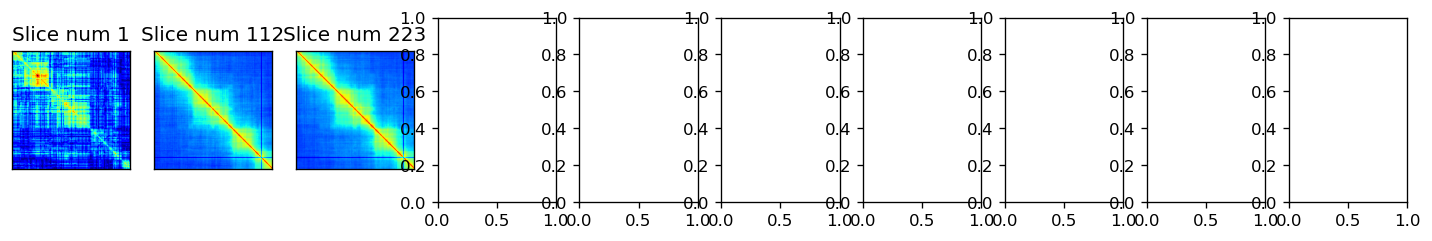

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(15, 2),dpi=120)
for i, slice_num in enumerate(slice_nums):
    if i < 10:
        ax[i].imshow(gam_D_local[i], cmap='jet')
        ax[i].set_title(f'Slice num {slice_num}')
        #不显示刻度
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    # elif 10 <= i < 20:
    #     ax[1][i - 10].imshow(gam_D_local[i], cmap='jet')
    #     ax[1][i - 10].set_title(f'Slice num {slice_num}')
    #     ax[1][i-10].set_xticks([])
    #     ax[1][i-10].set_yticks([])



fig.subplots_adjust(hspace=0.5)
fig.suptitle(f"chr10 simulation Linkage Matrix {region_local} ", fontsize=16) 
plt.show()

In [ ]:
pcorrs_D = []
scorrs_D = []
ssmis_D = []
rms_D = []

for i in gam_D:
    mat1= i
    mat2 = data_gam_chr4_40kb
    print(mat1.shape,mat2.shape)
    cor_list = mat_cor_with_na(mat1,mat2,sample=False)
        
    pcorrs_D.append(cor_list[0])
    scorrs_D.append(cor_list[1])
    ssmis_D.append(cor_list[2])
    rms_D.append(cor_list[3])


(3891, 3891) (3891, 3891)
length is 14137600
(3891, 3891) (3891, 3891)
length is 14137600
(3891, 3891) (3891, 3891)
length is 14137600


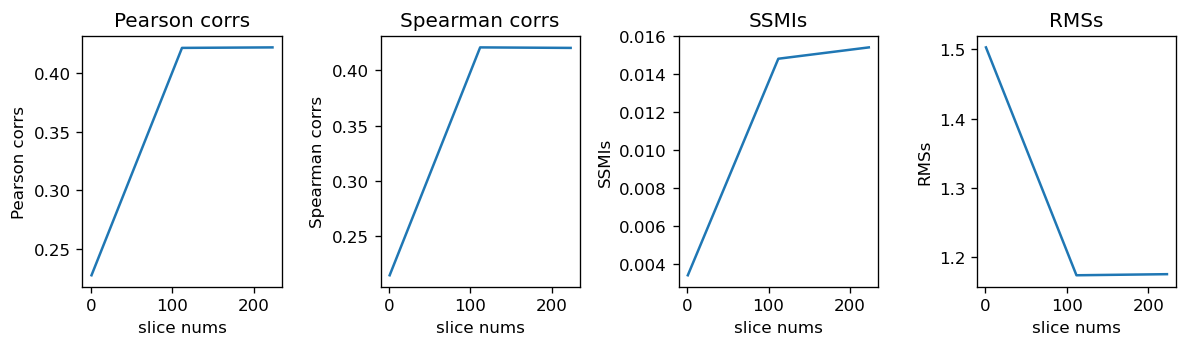

In [94]:

# build pd.df
slice_width_stats = pd.DataFrame({'slice_nums':slice_nums[0:3],
                                  'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D, 'rms_D':rms_D,})
plot_metrics(slice_width_stats['slice_nums'],"slice nums",slice_width_stats['pcorrs_D'],slice_width_stats['scorrs_D'],slice_width_stats['ssmis_D'],slice_width_stats['rms_D'])

## Thick

In [79]:
def generate_slices_uniform(tdg_path,CpG_df,slice_width=6,slice_num=1):
    tdg = pd.read_csv(tdg_path,sep="\t",header = None)
    tdg.columns = ["chrom","start","x","y","z"]
    tdg['key'] = tdg['chrom'].astype(str) + '_' + tdg['start'].astype(str)
    dup_counts = tdg['key'].value_counts()

    # 筛选出出现次数大于1的键（即重复键）
    dup_keys = dup_counts[dup_counts > 1]


    # print(CpG_df.head())
    tdg["start"] = tdg["start"].astype(int)
    tdg["pos"] = tdg["start"] + 20000
    # print(tdg.head())

    slices = []
    for slice in range(slice_num):
        rotated = point_cloud_rotation(tdg[["x","y","z"]].values,
                                        x_angle=np.random.uniform(0, 2*np.pi),
                                        y_angle=np.random.uniform(0, 2*np.pi),
                                        z_angle=np.random.uniform(0, 2*np.pi)
                                        )

        tdg_temp = tdg[["chrom","pos"]]
        tdg_temp = tdg_temp.assign(x=rotated[:,0],y=rotated[:,1],z=rotated[:,2])
        
        xrange = (tdg_temp["x"].min(),tdg_temp["x"].max())
        
        slice_upper = np.random.uniform(xrange[0]+slice_width,xrange[1])
        slice_lower = slice_upper - slice_width

        slice_tmp = tdg_temp.query(f'x > @slice_lower & x < @slice_upper').assign(inslice = lambda x: 1)[["chrom","pos","inslice"]]
        slice = pd.merge(CpG_df,slice_tmp,how="left").fillna(0)  
        slices.append(slice["inslice"].values)
    return slices

In [86]:
df_bin = df_bin_mm9_40kb
region = "chr4(mat)"
region_local = "chr4(mat):80000000-90000000"

thick_nums = np.linspace(2,10,10)
gam_D = []
gam_D_local = []
for thick in thick_nums:
    slice_results = []   
    for tdg_path in tqdm.tqdm(tdg_paths_40k2_mm9):
        cellname = tdg_path.split('/')[-2]
        slices_result = generate_slices_uniform(tdg_path, CpG_df=df_bin, slice_width=thick, slice_num=100)
        slice_results.append(slices_result)  
    # 将结果转换为numpy数组
    slices = np.array([item for sublist in slice_results for item in sublist]).T
    
    mat_index = df_bin[df_bin['chrom'] == region.split(':')[0]].index
    slices_temp = slices[mat_index,:]
    mean_slices = slices_temp.mean(axis=1)
    mean_both = slices_temp @ slices_temp.T / slices_temp.shape[1]
    mean_product = np.outer(mean_slices, mean_slices)
    gam_matrix = mean_both - mean_product
    gam_D.append(gam_matrix)

    mat_index_local = df_bin[df_bin['chrom'] == region_local.split(':')[0]].query('start >= {} & stop <= {}'.format(region_local.split(':')[1].split('-')[0], region_local.split(':')[1].split('-')[1])).index
    slices_temp_local = slices[mat_index_local,:]
    mean_slices_local = slices_temp_local.mean(axis=1)
    mean_both_local = slices_temp_local @ slices_temp_local.T / slices_temp_local.shape[1]
    mean_product_local = np.outer(mean_slices_local, mean_slices_local)
    gam_matrix_local = mean_both_local - mean_product_local
    gam_D_local.append(gam_matrix_local)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [1:32:58<00:00, 29.21s/it]


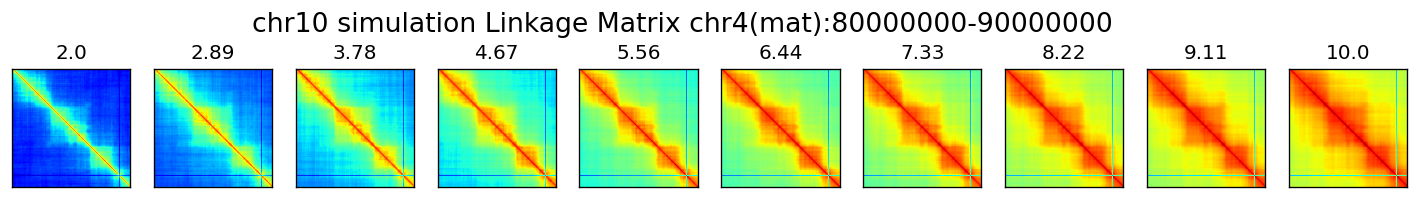

In [87]:
fig, ax = plt.subplots(1, 10, figsize=(15, 2),dpi=120)
for i, thick in enumerate(thick_nums):
    thick = np.round(thick,2)
    if i < 10:
        ax[i].imshow(gam_D_local[i], cmap='jet')
        ax[i].set_title(f'{thick}')
        #不显示刻度
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    # elif 10 <= i < 20:
    #     ax[1][i - 10].imshow(gam_D_local[i], cmap='jet')
    #     ax[1][i - 10].set_title(f'{thick}')
    #     ax[1][i-10].set_xticks([])
    #     ax[1][i-10].set_yticks([])



fig.subplots_adjust(hspace=0.5)
fig.suptitle(f"chr10 simulation Linkage Matrix {region_local} ", fontsize=16) 
plt.show()

length is 14137600
length is 14137600
length is 14137600
length is 14137600
length is 14137600
length is 14137600
length is 14137600
length is 14137600
length is 14137600
length is 14137600


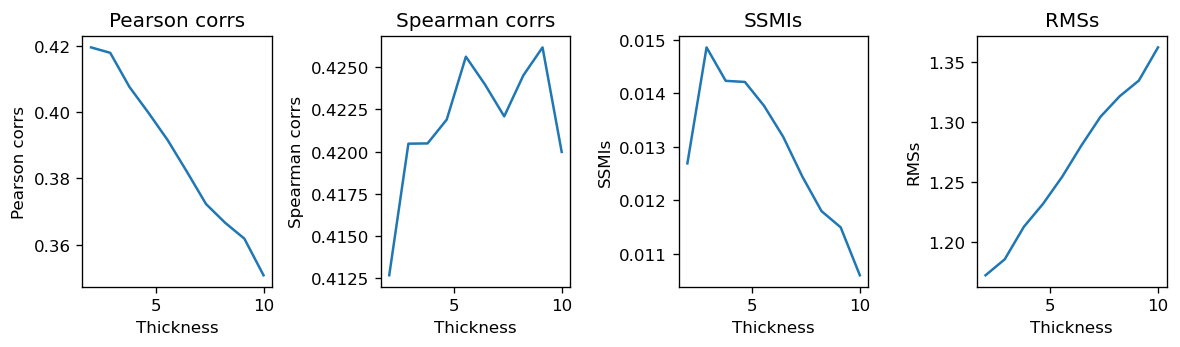

In [88]:
pcorrs_D = []
scorrs_D = []
ssmis_D = []
rms_D = []

for i in gam_D:
    mat1= i
    mat2 = data_gam_chr4_40kb
    cor_list = mat_cor_with_na(mat1,mat2,sample=False)
        
    pcorrs_D.append(cor_list[0])
    scorrs_D.append(cor_list[1])
    ssmis_D.append(cor_list[2])
    rms_D.append(cor_list[3])
# build pd.df
slice_width_stats = pd.DataFrame({'Thickness':thick_nums,
                                  'pcorrs_D':pcorrs_D,'scorrs_D':scorrs_D, 'ssmis_D':ssmis_D, 'rms_D':rms_D,
                                 }
                                )
plot_metrics(slice_width_stats['Thickness'],"Thickness",slice_width_stats['pcorrs_D'],slice_width_stats['scorrs_D'],slice_width_stats['ssmis_D'],slice_width_stats['rms_D'])

## 生成table

In [8]:
slice_num = 120
slice_width = 2.5

In [13]:
ref = "mm9"
df_bin = df_bin_mm9_40kb
for chr in chr_list:
    if not os.path.exists(f"silico_dprime/{ref}/ESC2_40kb_{slice_num}_{slice_width}_{chr}_dprime.npy"):
        region = f"{chr}(mat)"
        print(region)
        df_slice_results_all = df_bin[['chrom','start','stop']]
        slice_results = []
        new_columns = {} 

        slice_results = []   
        for tdg_path in tdg_paths_40k2_mm9[0:1]:
            cellname = tdg_path.split('/')[-2]
            slices_result = generate_slices_uniform(tdg_path, CpG_df=df_bin, slice_width=slice_width, slice_num=slice_num)
            slice_results.append(slices_result)  
            for i, result in enumerate(slices_result):
                column_name = f"{cellname}_np{i+1}"
                new_columns[column_name] = result.astype(int)
        
        slices = np.array([item for sublist in slice_results for item in sublist]).T
        mat_index = df_bin[df_bin['chrom'] == region].index
        slices_temp = slices[mat_index,:]
        mean_slices = slices_temp.mean(axis=1)
        mean_both = slices_temp @ slices_temp.T / slices_temp.shape[1]
        mean_product = np.outer(mean_slices, mean_slices)
        gam_matrix = mean_both - mean_product
        np.save(f"silico_dprime/{ref}/ESC2_40kb_{slice_num}_{slice_width}_{chr}_dprime.npy",gam_matrix)
        
      
        new_columns_df = pd.DataFrame(new_columns)
        new_columns_df = new_columns_df.reset_index(drop=True)
        
        df_slice_results = pd.concat([df_slice_results_all, new_columns_df], axis=1)
        df_slice_results.rename(columns={'end': 'stop'}, inplace=True)
        df_slice_results = df_slice_results.query("chrom==@region")
        df_slice_results.index = range(len(df_slice_results))
        df_slice_results.to_csv(f"silico_segregation/{ref}/ESC2_40kb_{slice_num}_{slice_width}_{chr}_segration_table.tsv", sep="\t",index=False)

        df_slice_results_detection = df_slice_results.set_index(list(df_slice_results.columns[:3]))
        
        df_slice_results_detection['detection frequency'] = df_slice_results_detection.sum(axis=1) / len(df_slice_results_detection.columns)
        df_slice_results_detection = df_slice_results_detection[['detection frequency']]
        df_slice_results_detection.to_csv(f"detection/{ref}/ESC2_40kb_{slice_num}_{slice_width}_{chr}_detection.tsv",sep="\t")
        

chr11(mat)
chr12(mat)
chr13(mat)
chr14(mat)
chr15(mat)
chr16(mat)
chr17(mat)
chr18(mat)
chr19(mat)


In [20]:
chr = "chr13"
pd.read_csv(f"detection/{ref}/ESC2_40kb_{slice_num}_{slice_width}_{chr}_detection.tsv",sep="\t")

,chrom,start,stop,detection frequency
0,chr13(mat),0,40000,0.000000
1,chr13(mat),40000,80000,0.000000
2,chr13(mat),80000,120000,0.000000
3,chr13(mat),120000,160000,0.000000
4,chr13(mat),160000,200000,0.000000
...,...,...,...,...
3003,chr13(mat),120120000,120160000,0.041667
3004,chr13(mat),120160000,120200000,0.033333
3005,chr13(mat),120200000,120240000,0.041667
3006,chr13(mat),120240000,120280000,0.041667
